In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [4]:
run_name = "01_21_20_run_01"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [5]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [6]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [7]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [8]:
from pore_utils import smith_waterman as s_w

In [9]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [10]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [11]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

[15:15:00 - __main__] Getting molbit sequences.
[15:15:00 - __main__] Locating fastq files.
[15:15:00 - __main__] Running SW, one fastq at a time.
[15:15:00 - __main__] Starting fastq (0 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_0_0.fastq


[########################################] | 100% Completed | 44.1s


[15:15:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_0_0.tsv
[15:15:45 - __main__] Starting fastq (1 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_0_1.fastq


[########################################] | 100% Completed | 13.2s


[15:15:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_0_1.tsv
[15:15:58 - __main__] Starting fastq (2 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_0_2.fastq


[########################################] | 100% Completed | 43.9s


[15:16:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_0_2.tsv
[15:16:43 - __main__] Starting fastq (3 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_0_3.fastq


[########################################] | 100% Completed | 16.9s


[15:17:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_0_3.tsv
[15:17:00 - __main__] Starting fastq (4 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_1_0.fastq


[########################################] | 100% Completed | 59.3s


[15:17:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_1_0.tsv
[15:18:00 - __main__] Starting fastq (5 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_1_1.fastq


[########################################] | 100% Completed | 44.3s


[15:18:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_1_1.tsv
[15:18:44 - __main__] Starting fastq (6 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_1_2.fastq


[########################################] | 100% Completed | 17.9s


[15:19:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_1_2.tsv
[15:19:03 - __main__] Starting fastq (7 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_1_3.fastq


[########################################] | 100% Completed |  7.3s


[15:19:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_1_3.tsv
[15:19:10 - __main__] Starting fastq (8 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_2_0.fastq


[########################################] | 100% Completed | 24.2s


[15:19:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_2_0.tsv
[15:19:35 - __main__] Starting fastq (9 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_2_1.fastq


[########################################] | 100% Completed | 35.6s


[15:20:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_2_1.tsv
[15:20:11 - __main__] Starting fastq (10 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_2_2.fastq


[########################################] | 100% Completed | 15.5s


[15:20:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_2_2.tsv
[15:20:27 - __main__] Starting fastq (11 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_2_3.fastq


[########################################] | 100% Completed | 55.6s


[15:21:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_2_3.tsv
[15:21:23 - __main__] Starting fastq (12 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_3_0.fastq


[########################################] | 100% Completed |  1min 25.0s


[15:22:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_3_0.tsv
[15:22:49 - __main__] Starting fastq (13 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_3_1.fastq


[########################################] | 100% Completed | 26.0s


[15:23:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_3_1.tsv
[15:23:15 - __main__] Starting fastq (14 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_3_2.fastq


[########################################] | 100% Completed | 22.2s


[15:23:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_3_2.tsv
[15:23:38 - __main__] Starting fastq (15 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_4_0.fastq


[########################################] | 100% Completed | 59.4s


[15:24:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_4_0.tsv
[15:24:38 - __main__] Starting fastq (16 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_4_1.fastq


[########################################] | 100% Completed | 41.1s


[15:25:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_4_1.tsv
[15:25:20 - __main__] Starting fastq (17 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_4_2.fastq


[########################################] | 100% Completed | 33.0s


[15:25:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_4_2.tsv
[15:25:53 - __main__] Starting fastq (18 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_3_3.fastq


[########################################] | 100% Completed |  2.6s


[15:25:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_3_3.tsv
[15:25:56 - __main__] Starting fastq (19 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_5_0.fastq


[########################################] | 100% Completed | 56.1s


[15:26:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_5_0.tsv
[15:26:53 - __main__] Starting fastq (20 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_5_1.fastq


[########################################] | 100% Completed |  8.3s


[15:27:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_5_1.tsv
[15:27:02 - __main__] Starting fastq (21 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_5_2.fastq


[########################################] | 100% Completed |  1min  9.4s


[15:28:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_5_2.tsv
[15:28:12 - __main__] Starting fastq (22 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_6_0.fastq


[########################################] | 100% Completed | 39.1s


[15:28:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_6_0.tsv
[15:28:51 - __main__] Starting fastq (23 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_4_3.fastq


[########################################] | 100% Completed |  1.5s


[15:28:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_4_3.tsv
[15:28:53 - __main__] Starting fastq (24 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_5_3.fastq


[########################################] | 100% Completed |  1.0s


[15:28:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_5_3.tsv
[15:28:55 - __main__] Starting fastq (25 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_6_1.fastq


[########################################] | 100% Completed | 44.2s


[15:29:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_6_1.tsv
[15:29:39 - __main__] Starting fastq (26 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_6_2.fastq


[########################################] | 100% Completed | 26.6s


[15:30:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_6_2.tsv
[15:30:06 - __main__] Starting fastq (27 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_7_0.fastq


[########################################] | 100% Completed | 36.2s


[15:30:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_7_0.tsv
[15:30:43 - __main__] Starting fastq (28 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_7_1.fastq


[########################################] | 100% Completed | 33.8s


[15:31:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_7_1.tsv
[15:31:17 - __main__] Starting fastq (29 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_7_2.fastq


[########################################] | 100% Completed | 51.9s


[15:32:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_7_2.tsv
[15:32:10 - __main__] Starting fastq (30 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_6_3.fastq


[########################################] | 100% Completed | 23.6s


[15:32:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_6_3.tsv
[15:32:34 - __main__] Starting fastq (31 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_8_0.fastq


[########################################] | 100% Completed | 56.7s


[15:33:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_8_0.tsv
[15:33:31 - __main__] Starting fastq (32 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_7_3.fastq


[########################################] | 100% Completed | 10.6s


[15:33:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_7_3.tsv
[15:33:42 - __main__] Starting fastq (33 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_8_1.fastq


[########################################] | 100% Completed | 49.7s


[15:34:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_8_1.tsv
[15:34:32 - __main__] Starting fastq (34 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_8_2.fastq


[########################################] | 100% Completed | 19.1s


[15:34:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_8_2.tsv
[15:34:52 - __main__] Starting fastq (35 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_8_3.fastq


[########################################] | 100% Completed |  8.5s


[15:35:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_8_3.tsv
[15:35:01 - __main__] Starting fastq (36 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_9_0.fastq


[########################################] | 100% Completed | 45.1s


[15:35:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_9_0.tsv
[15:35:46 - __main__] Starting fastq (37 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_9_1.fastq


[########################################] | 100% Completed | 24.9s


[15:36:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_9_1.tsv
[15:36:12 - __main__] Starting fastq (38 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_9_2.fastq


[########################################] | 100% Completed | 36.5s


[15:36:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_9_2.tsv
[15:36:49 - __main__] Starting fastq (39 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_9_3.fastq


[########################################] | 100% Completed | 27.6s


[15:37:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_9_3.tsv
[15:37:17 - __main__] Starting fastq (40 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_10_0.fastq


[########################################] | 100% Completed | 47.1s


[15:38:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_10_0.tsv
[15:38:05 - __main__] Starting fastq (41 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_10_1.fastq


[########################################] | 100% Completed | 51.7s


[15:38:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_10_1.tsv
[15:38:57 - __main__] Starting fastq (42 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_10_2.fastq


[########################################] | 100% Completed | 15.4s


[15:39:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_10_2.tsv
[15:39:13 - __main__] Starting fastq (43 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_11_0.fastq


[########################################] | 100% Completed |  1min 33.3s


[15:40:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_11_0.tsv
[15:40:47 - __main__] Starting fastq (44 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_10_3.fastq


[########################################] | 100% Completed | 17.9s


[15:41:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_10_3.tsv
[15:41:05 - __main__] Starting fastq (45 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_11_1.fastq


[########################################] | 100% Completed | 22.8s


[15:41:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_11_1.tsv
[15:41:28 - __main__] Starting fastq (46 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_11_2.fastq


[########################################] | 100% Completed | 12.5s


[15:41:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_11_2.tsv
[15:41:41 - __main__] Starting fastq (47 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_12_0.fastq


[########################################] | 100% Completed | 47.3s


[15:42:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_12_0.tsv
[15:42:29 - __main__] Starting fastq (48 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_12_1.fastq


[########################################] | 100% Completed | 28.7s


[15:42:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_12_1.tsv
[15:42:58 - __main__] Starting fastq (49 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_11_3.fastq


[########################################] | 100% Completed |  1.0s


[15:43:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_11_3.tsv
[15:43:00 - __main__] Starting fastq (50 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_12_2.fastq


[########################################] | 100% Completed | 54.0s


[15:43:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_12_2.tsv
[15:43:54 - __main__] Starting fastq (51 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_13_0.fastq


[########################################] | 100% Completed | 32.8s


[15:44:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_13_0.tsv
[15:44:28 - __main__] Starting fastq (52 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_13_1.fastq


[########################################] | 100% Completed |  1min  8.3s


[15:45:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_13_1.tsv
[15:45:37 - __main__] Starting fastq (53 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_12_3.fastq


[########################################] | 100% Completed |  1.0s


[15:45:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_12_3.tsv
[15:45:38 - __main__] Starting fastq (54 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_13_2.fastq


[########################################] | 100% Completed | 24.4s


[15:46:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_13_2.tsv
[15:46:03 - __main__] Starting fastq (55 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_13_3.fastq


[########################################] | 100% Completed | 10.8s


[15:46:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_13_3.tsv
[15:46:14 - __main__] Starting fastq (56 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_14_0.fastq


[########################################] | 100% Completed | 21.7s


[15:46:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_14_0.tsv
[15:46:36 - __main__] Starting fastq (57 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_14_1.fastq


[########################################] | 100% Completed | 20.2s


[15:46:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_14_1.tsv
[15:46:57 - __main__] Starting fastq (58 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_14_2.fastq


[########################################] | 100% Completed | 57.2s


[15:47:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_14_2.tsv
[15:47:55 - __main__] Starting fastq (59 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_14_3.fastq


[########################################] | 100% Completed | 34.1s


[15:48:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_14_3.tsv
[15:48:29 - __main__] Starting fastq (60 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_15_0.fastq


[########################################] | 100% Completed | 36.3s


[15:49:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_15_0.tsv
[15:49:06 - __main__] Starting fastq (61 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_15_1.fastq


[########################################] | 100% Completed | 56.0s


[15:50:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_15_1.tsv
[15:50:03 - __main__] Starting fastq (62 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_15_2.fastq


[########################################] | 100% Completed | 31.2s


[15:50:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_15_2.tsv
[15:50:35 - __main__] Starting fastq (63 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_16_0.fastq


[########################################] | 100% Completed | 41.5s


[15:51:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_16_0.tsv
[15:51:16 - __main__] Starting fastq (64 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_16_1.fastq


[########################################] | 100% Completed | 50.3s


[15:52:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_16_1.tsv
[15:52:07 - __main__] Starting fastq (65 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_15_3.fastq


[########################################] | 100% Completed | 10.0s


[15:52:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_15_3.tsv
[15:52:18 - __main__] Starting fastq (66 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_16_2.fastq


[########################################] | 100% Completed | 26.0s


[15:52:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_16_2.tsv
[15:52:44 - __main__] Starting fastq (67 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_16_3.fastq


[########################################] | 100% Completed | 17.9s


[15:53:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_16_3.tsv
[15:53:03 - __main__] Starting fastq (68 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_17_0.fastq


[########################################] | 100% Completed | 38.5s


[15:53:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_17_0.tsv
[15:53:42 - __main__] Starting fastq (69 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_17_1.fastq


[########################################] | 100% Completed | 49.3s


[15:54:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_17_1.tsv
[15:54:32 - __main__] Starting fastq (70 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_17_2.fastq


[########################################] | 100% Completed | 42.5s


[15:55:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_17_2.tsv
[15:55:15 - __main__] Starting fastq (71 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_18_0.fastq


[########################################] | 100% Completed | 38.1s


[15:55:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_18_0.tsv
[15:55:53 - __main__] Starting fastq (72 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_18_1.fastq


[########################################] | 100% Completed | 57.1s


[15:56:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_18_1.tsv
[15:56:51 - __main__] Starting fastq (73 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_17_3.fastq


[########################################] | 100% Completed |  2.9s


[15:56:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_17_3.tsv
[15:56:54 - __main__] Starting fastq (74 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_18_2.fastq


[########################################] | 100% Completed | 14.6s


[15:57:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_18_2.tsv
[15:57:09 - __main__] Starting fastq (75 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_18_3.fastq


[########################################] | 100% Completed | 19.4s


[15:57:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_18_3.tsv
[15:57:29 - __main__] Starting fastq (76 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_19_0.fastq


[########################################] | 100% Completed | 35.9s


[15:58:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_19_0.tsv
[15:58:05 - __main__] Starting fastq (77 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_19_1.fastq


[########################################] | 100% Completed | 13.7s


[15:58:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_19_1.tsv
[15:58:20 - __main__] Starting fastq (78 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_19_2.fastq


[########################################] | 100% Completed | 38.6s


[15:58:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_19_2.tsv
[15:58:59 - __main__] Starting fastq (79 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_20_0.fastq


[########################################] | 100% Completed | 46.0s


[15:59:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_20_0.tsv
[15:59:45 - __main__] Starting fastq (80 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_19_3.fastq


[########################################] | 100% Completed | 42.3s


[16:00:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_19_3.tsv
[16:00:28 - __main__] Starting fastq (81 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_20_1.fastq


[########################################] | 100% Completed | 27.6s


[16:00:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_20_1.tsv
[16:00:56 - __main__] Starting fastq (82 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_20_2.fastq


[########################################] | 100% Completed | 56.4s


[16:01:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_20_2.tsv
[16:01:53 - __main__] Starting fastq (83 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_21_0.fastq


[########################################] | 100% Completed |  1min  7.1s


[16:03:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_21_0.tsv
[16:03:01 - __main__] Starting fastq (84 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_21_1.fastq


[########################################] | 100% Completed | 41.6s


[16:03:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_21_1.tsv
[16:03:43 - __main__] Starting fastq (85 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_20_3.fastq


[########################################] | 100% Completed |  1.0s


[16:03:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_20_3.tsv
[16:03:44 - __main__] Starting fastq (86 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_21_2.fastq


[########################################] | 100% Completed | 20.2s


[16:04:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_21_2.tsv
[16:04:05 - __main__] Starting fastq (87 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_22_0.fastq


[########################################] | 100% Completed | 51.7s


[16:04:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_22_0.tsv
[16:04:57 - __main__] Starting fastq (88 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_22_1.fastq


[########################################] | 100% Completed | 36.3s


[16:05:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_22_1.tsv
[16:05:34 - __main__] Starting fastq (89 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_21_3.fastq


[########################################] | 100% Completed |  0.9s


[16:05:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_21_3.tsv
[16:05:36 - __main__] Starting fastq (90 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_22_2.fastq


[########################################] | 100% Completed | 13.6s


[16:05:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_22_2.tsv
[16:05:50 - __main__] Starting fastq (91 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_23_0.fastq


[########################################] | 100% Completed | 23.3s


[16:06:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_23_0.tsv
[16:06:13 - __main__] Starting fastq (92 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_23_1.fastq


[########################################] | 100% Completed | 52.3s


[16:07:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_23_1.tsv
[16:07:06 - __main__] Starting fastq (93 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_22_3.fastq


[########################################] | 100% Completed | 24.1s


[16:07:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_22_3.tsv
[16:07:31 - __main__] Starting fastq (94 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_24_0.fastq


[########################################] | 100% Completed |  1min  5.3s


[16:08:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_24_0.tsv
[16:08:37 - __main__] Starting fastq (95 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_23_2.fastq


[########################################] | 100% Completed |  4.0s


[16:08:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_23_2.tsv
[16:08:41 - __main__] Starting fastq (96 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_24_1.fastq


[########################################] | 100% Completed | 27.3s


[16:09:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_24_1.tsv
[16:09:09 - __main__] Starting fastq (97 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_24_2.fastq


[########################################] | 100% Completed | 36.2s


[16:09:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_24_2.tsv
[16:09:46 - __main__] Starting fastq (98 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_25_0.fastq


[########################################] | 100% Completed | 54.0s


[16:10:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_25_0.tsv
[16:10:40 - __main__] Starting fastq (99 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_23_3.fastq


[########################################] | 100% Completed | 52.5s


[16:11:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_23_3.tsv
[16:11:33 - __main__] Starting fastq (100 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_25_1.fastq


[########################################] | 100% Completed | 10.1s


[16:11:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_25_1.tsv
[16:11:44 - __main__] Starting fastq (101 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_26_0.fastq


[########################################] | 100% Completed | 41.2s


[16:12:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_26_0.tsv
[16:12:26 - __main__] Starting fastq (102 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_25_2.fastq


[########################################] | 100% Completed | 53.4s


[16:13:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_25_2.tsv
[16:13:20 - __main__] Starting fastq (103 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_24_3.fastq


[########################################] | 100% Completed |  1.0s


[16:13:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_24_3.tsv
[16:13:21 - __main__] Starting fastq (104 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_25_3.fastq


[########################################] | 100% Completed | 13.8s


[16:13:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_25_3.tsv
[16:13:35 - __main__] Starting fastq (105 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_26_1.fastq


[########################################] | 100% Completed | 42.4s


[16:14:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_26_1.tsv
[16:14:18 - __main__] Starting fastq (106 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_27_0.fastq


[########################################] | 100% Completed | 58.6s


[16:15:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_27_0.tsv
[16:15:18 - __main__] Starting fastq (107 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_26_2.fastq


[########################################] | 100% Completed |  1.6s


[16:15:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_26_2.tsv
[16:15:20 - __main__] Starting fastq (108 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_27_1.fastq


[########################################] | 100% Completed | 38.9s


[16:15:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_27_1.tsv
[16:15:59 - __main__] Starting fastq (109 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_27_2.fastq


[########################################] | 100% Completed | 28.5s


[16:16:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_27_2.tsv
[16:16:28 - __main__] Starting fastq (110 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_27_3.fastq


[########################################] | 100% Completed |  5.1s


[16:16:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_27_3.tsv
[16:16:34 - __main__] Starting fastq (111 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_28_0.fastq


[########################################] | 100% Completed | 23.8s


[16:16:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_28_0.tsv
[16:16:58 - __main__] Starting fastq (112 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_28_1.fastq


[########################################] | 100% Completed |  1min 20.3s


[16:18:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_28_1.tsv
[16:18:19 - __main__] Starting fastq (113 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_28_2.fastq


[########################################] | 100% Completed |  2.1s


[16:18:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_28_2.tsv
[16:18:21 - __main__] Starting fastq (114 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_29_0.fastq


[########################################] | 100% Completed | 48.2s


[16:19:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_29_0.tsv
[16:19:10 - __main__] Starting fastq (115 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_29_1.fastq


[########################################] | 100% Completed |  1min  4.6s


[16:20:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_29_1.tsv
[16:20:15 - __main__] Starting fastq (116 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_26_3.fastq


[########################################] | 100% Completed | 45.0s


[16:21:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_26_3.tsv
[16:21:01 - __main__] Starting fastq (117 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_29_2.fastq


[########################################] | 100% Completed | 18.0s


[16:21:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_29_2.tsv
[16:21:19 - __main__] Starting fastq (118 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_30_0.fastq


[########################################] | 100% Completed | 23.8s


[16:21:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_30_0.tsv
[16:21:43 - __main__] Starting fastq (119 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_30_1.fastq


[########################################] | 100% Completed | 56.8s


[16:22:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_30_1.tsv
[16:22:41 - __main__] Starting fastq (120 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_30_2.fastq


[########################################] | 100% Completed | 47.4s


[16:23:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_30_2.tsv
[16:23:29 - __main__] Starting fastq (121 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_31_0.fastq


[########################################] | 100% Completed | 44.3s


[16:24:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_31_0.tsv
[16:24:14 - __main__] Starting fastq (122 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_31_1.fastq


[########################################] | 100% Completed | 19.3s


[16:24:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_31_1.tsv
[16:24:33 - __main__] Starting fastq (123 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_28_3.fastq


[########################################] | 100% Completed | 20.0s


[16:24:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_28_3.tsv
[16:24:54 - __main__] Starting fastq (124 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_29_3.fastq


[########################################] | 100% Completed |  1.0s


[16:24:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_29_3.tsv
[16:24:55 - __main__] Starting fastq (125 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_30_3.fastq


[########################################] | 100% Completed |  0.9s


[16:24:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_30_3.tsv
[16:24:57 - __main__] Starting fastq (126 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_31_2.fastq


[########################################] | 100% Completed |  3.7s


[16:25:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_31_2.tsv
[16:25:01 - __main__] Starting fastq (127 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_32_0.fastq


[########################################] | 100% Completed |  1min 29.8s


[16:26:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_32_0.tsv
[16:26:31 - __main__] Starting fastq (128 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_32_1.fastq


[########################################] | 100% Completed | 24.9s


[16:26:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_32_1.tsv
[16:26:57 - __main__] Starting fastq (129 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_31_3.fastq


[########################################] | 100% Completed |  1min  0.1s


[16:27:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_31_3.tsv
[16:27:57 - __main__] Starting fastq (130 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_32_2.fastq


[########################################] | 100% Completed |  6.4s


[16:28:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_32_2.tsv
[16:28:04 - __main__] Starting fastq (131 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_33_0.fastq


[########################################] | 100% Completed |  1min 14.8s


[16:29:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_33_0.tsv
[16:29:19 - __main__] Starting fastq (132 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_33_1.fastq


[########################################] | 100% Completed | 52.9s


[16:30:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_33_1.tsv
[16:30:13 - __main__] Starting fastq (133 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_32_3.fastq


[########################################] | 100% Completed |  6.5s


[16:30:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_32_3.tsv
[16:30:20 - __main__] Starting fastq (134 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_33_2.fastq


[########################################] | 100% Completed |  3.7s


[16:30:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_33_2.tsv
[16:30:24 - __main__] Starting fastq (135 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_34_0.fastq


[########################################] | 100% Completed | 45.9s


[16:31:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_34_0.tsv
[16:31:10 - __main__] Starting fastq (136 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_33_3.fastq


[########################################] | 100% Completed |  0.9s


[16:31:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_33_3.tsv
[16:31:12 - __main__] Starting fastq (137 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_34_1.fastq


[########################################] | 100% Completed |  1min  4.5s


[16:32:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_34_1.tsv
[16:32:17 - __main__] Starting fastq (138 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_34_2.fastq


[########################################] | 100% Completed |  1.0s


[16:32:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_34_2.tsv
[16:32:18 - __main__] Starting fastq (139 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_35_0.fastq


[########################################] | 100% Completed |  1min 18.4s


[16:33:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_35_0.tsv
[16:33:37 - __main__] Starting fastq (140 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_35_1.fastq


[########################################] | 100% Completed | 22.9s


[16:34:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_35_1.tsv
[16:34:01 - __main__] Starting fastq (141 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_35_2.fastq


[########################################] | 100% Completed | 26.7s


[16:34:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_35_2.tsv
[16:34:28 - __main__] Starting fastq (142 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_34_3.fastq


[########################################] | 100% Completed | 20.1s


[16:34:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_34_3.tsv
[16:34:48 - __main__] Starting fastq (143 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_36_0.fastq


[########################################] | 100% Completed |  1min 25.4s


[16:36:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_36_0.tsv
[16:36:15 - __main__] Starting fastq (144 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_36_1.fastq


[########################################] | 100% Completed | 28.1s


[16:36:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_36_1.tsv
[16:36:43 - __main__] Starting fastq (145 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_35_3.fastq


[########################################] | 100% Completed |  1.9s


[16:36:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_35_3.tsv
[16:36:45 - __main__] Starting fastq (146 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_36_2.fastq


[########################################] | 100% Completed | 16.2s


[16:37:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_36_2.tsv
[16:37:02 - __main__] Starting fastq (147 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_37_0.fastq


[########################################] | 100% Completed | 33.3s


[16:37:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_37_0.tsv
[16:37:36 - __main__] Starting fastq (148 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_37_1.fastq


[########################################] | 100% Completed | 23.1s


[16:37:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_37_1.tsv
[16:38:00 - __main__] Starting fastq (149 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_37_2.fastq


[########################################] | 100% Completed |  1min 13.8s


[16:39:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_37_2.tsv
[16:39:14 - __main__] Starting fastq (150 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_37_3.fastq


[########################################] | 100% Completed |  3.4s


[16:39:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_37_3.tsv
[16:39:18 - __main__] Starting fastq (151 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_38_0.fastq


[########################################] | 100% Completed | 35.4s


[16:39:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_38_0.tsv
[16:39:54 - __main__] Starting fastq (152 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_38_1.fastq


[########################################] | 100% Completed | 26.8s


[16:40:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_38_1.tsv
[16:40:21 - __main__] Starting fastq (153 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_38_2.fastq


[########################################] | 100% Completed | 40.6s


[16:41:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_38_2.tsv
[16:41:02 - __main__] Starting fastq (154 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_39_0.fastq


[########################################] | 100% Completed | 28.2s


[16:41:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_39_0.tsv
[16:41:31 - __main__] Starting fastq (155 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_36_3.fastq


[########################################] | 100% Completed |  0.8s


[16:41:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_36_3.tsv
[16:41:32 - __main__] Starting fastq (156 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_39_1.fastq


[########################################] | 100% Completed |  1min  9.9s


[16:42:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_39_1.tsv
[16:42:43 - __main__] Starting fastq (157 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_38_3.fastq


[########################################] | 100% Completed | 26.5s


[16:43:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_38_3.tsv
[16:43:10 - __main__] Starting fastq (158 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_39_2.fastq


[########################################] | 100% Completed | 15.6s


[16:43:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_39_2.tsv
[16:43:26 - __main__] Starting fastq (159 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_39_3.fastq


[########################################] | 100% Completed | 16.1s


[16:43:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_39_3.tsv
[16:43:42 - __main__] Starting fastq (160 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_40_0.fastq


[########################################] | 100% Completed | 25.7s


[16:44:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_40_0.tsv
[16:44:09 - __main__] Starting fastq (161 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_40_1.fastq


[########################################] | 100% Completed | 34.7s


[16:44:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_40_1.tsv
[16:44:44 - __main__] Starting fastq (162 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_40_2.fastq


[########################################] | 100% Completed | 17.8s


[16:45:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_40_2.tsv
[16:45:02 - __main__] Starting fastq (163 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_40_3.fastq


[########################################] | 100% Completed | 51.7s


[16:45:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_40_3.tsv
[16:45:54 - __main__] Starting fastq (164 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_41_0.fastq


[########################################] | 100% Completed | 31.0s


[16:46:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_41_0.tsv
[16:46:26 - __main__] Starting fastq (165 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_41_1.fastq


[########################################] | 100% Completed | 15.1s


[16:46:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_41_1.tsv
[16:46:42 - __main__] Starting fastq (166 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_41_2.fastq


[########################################] | 100% Completed | 15.0s


[16:46:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_41_2.tsv
[16:46:57 - __main__] Starting fastq (167 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_41_3.fastq


[########################################] | 100% Completed |  1min  7.4s


[16:48:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_41_3.tsv
[16:48:05 - __main__] Starting fastq (168 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_42_0.fastq


[########################################] | 100% Completed | 32.4s


[16:48:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_42_0.tsv
[16:48:38 - __main__] Starting fastq (169 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_42_1.fastq


[########################################] | 100% Completed | 51.6s


[16:49:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_42_1.tsv
[16:49:30 - __main__] Starting fastq (170 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_42_2.fastq


[########################################] | 100% Completed | 47.8s


[16:50:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_42_2.tsv
[16:50:18 - __main__] Starting fastq (171 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_42_3.fastq


[########################################] | 100% Completed |  1.0s


[16:50:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_42_3.tsv
[16:50:20 - __main__] Starting fastq (172 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_43_0.fastq


[########################################] | 100% Completed | 40.0s


[16:51:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_43_0.tsv
[16:51:00 - __main__] Starting fastq (173 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_43_1.fastq


[########################################] | 100% Completed | 16.8s


[16:51:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_43_1.tsv
[16:51:18 - __main__] Starting fastq (174 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_43_2.fastq


[########################################] | 100% Completed |  2.8s


[16:51:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_43_2.tsv
[16:51:21 - __main__] Starting fastq (175 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_44_0.fastq


[########################################] | 100% Completed | 47.6s


[16:52:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_44_0.tsv
[16:52:09 - __main__] Starting fastq (176 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_44_1.fastq


[########################################] | 100% Completed | 29.2s


[16:52:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_44_1.tsv
[16:52:39 - __main__] Starting fastq (177 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_43_3.fastq


[########################################] | 100% Completed |  1min 13.7s


[16:53:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_43_3.tsv
[16:53:53 - __main__] Starting fastq (178 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_44_2.fastq


[########################################] | 100% Completed | 54.4s


[16:54:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_44_2.tsv
[16:54:48 - __main__] Starting fastq (179 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_45_0.fastq


[########################################] | 100% Completed | 50.4s


[16:55:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_45_0.tsv
[16:55:39 - __main__] Starting fastq (180 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_45_1.fastq


[########################################] | 100% Completed | 26.8s


[16:56:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_45_1.tsv
[16:56:06 - __main__] Starting fastq (181 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_45_2.fastq


[########################################] | 100% Completed | 35.7s


[16:56:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_45_2.tsv
[16:56:43 - __main__] Starting fastq (182 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_44_3.fastq


[########################################] | 100% Completed |  1.0s


[16:56:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_44_3.tsv
[16:56:44 - __main__] Starting fastq (183 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_45_3.fastq


[########################################] | 100% Completed | 19.7s


[16:57:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_45_3.tsv
[16:57:04 - __main__] Starting fastq (184 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_46_0.fastq


[########################################] | 100% Completed |  1min 23.6s


[16:58:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_46_0.tsv
[16:58:28 - __main__] Starting fastq (185 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_46_1.fastq


[########################################] | 100% Completed | 26.7s


[16:58:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_46_1.tsv
[16:58:56 - __main__] Starting fastq (186 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_46_2.fastq


[########################################] | 100% Completed | 16.6s


[16:59:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_46_2.tsv
[16:59:13 - __main__] Starting fastq (187 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_47_0.fastq


[########################################] | 100% Completed | 26.2s


[16:59:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_47_0.tsv
[16:59:39 - __main__] Starting fastq (188 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_46_3.fastq


[########################################] | 100% Completed |  1.8s


[16:59:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_46_3.tsv
[16:59:42 - __main__] Starting fastq (189 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_47_1.fastq


[########################################] | 100% Completed |  1min 10.0s


[17:00:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_47_1.tsv
[17:00:52 - __main__] Starting fastq (190 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_48_0.fastq


[########################################] | 100% Completed | 44.5s


[17:01:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_48_0.tsv
[17:01:37 - __main__] Starting fastq (191 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_47_2.fastq


[########################################] | 100% Completed | 18.3s


[17:01:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_47_2.tsv
[17:01:56 - __main__] Starting fastq (192 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_48_1.fastq


[########################################] | 100% Completed | 36.2s


[17:02:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_48_1.tsv
[17:02:33 - __main__] Starting fastq (193 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_49_0.fastq


[########################################] | 100% Completed | 49.0s


[17:03:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_49_0.tsv
[17:03:22 - __main__] Starting fastq (194 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_48_2.fastq


[########################################] | 100% Completed | 35.2s


[17:03:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_48_2.tsv
[17:03:58 - __main__] Starting fastq (195 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_49_1.fastq


[########################################] | 100% Completed |  1min 14.6s


[17:05:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_49_1.tsv
[17:05:13 - __main__] Starting fastq (196 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_50_0.fastq


[########################################] | 100% Completed |  1min 12.5s


[17:06:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_50_0.tsv
[17:06:26 - __main__] Starting fastq (197 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_49_2.fastq


[########################################] | 100% Completed |  1.0s


[17:06:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_49_2.tsv
[17:06:27 - __main__] Starting fastq (198 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_50_1.fastq


[########################################] | 100% Completed | 24.1s


[17:06:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_50_1.tsv
[17:06:52 - __main__] Starting fastq (199 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_47_3.fastq


[########################################] | 100% Completed | 16.5s


[17:07:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_47_3.tsv
[17:07:09 - __main__] Starting fastq (200 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_50_2.fastq


[########################################] | 100% Completed |  5.3s


[17:07:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_50_2.tsv
[17:07:15 - __main__] Starting fastq (201 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_51_0.fastq


[########################################] | 100% Completed | 32.1s


[17:07:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_51_0.tsv
[17:07:47 - __main__] Starting fastq (202 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_50_3.fastq


[########################################] | 100% Completed | 26.9s


[17:08:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_50_3.tsv
[17:08:15 - __main__] Starting fastq (203 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_48_3.fastq


[########################################] | 100% Completed | 13.8s


[17:08:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_48_3.tsv
[17:08:29 - __main__] Starting fastq (204 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_51_1.fastq


[########################################] | 100% Completed | 33.8s


[17:09:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_51_1.tsv
[17:09:04 - __main__] Starting fastq (205 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_52_0.fastq


[########################################] | 100% Completed | 45.3s


[17:09:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_52_0.tsv
[17:09:49 - __main__] Starting fastq (206 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_49_3.fastq


[########################################] | 100% Completed |  9.8s


[17:10:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_49_3.tsv
[17:10:00 - __main__] Starting fastq (207 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_51_2.fastq


[########################################] | 100% Completed |  1.1s


[17:10:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_51_2.tsv
[17:10:01 - __main__] Starting fastq (208 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_51_3.fastq


[########################################] | 100% Completed |  1min  1.7s


[17:11:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_51_3.tsv
[17:11:03 - __main__] Starting fastq (209 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_52_1.fastq


[########################################] | 100% Completed |  1min 11.7s


[17:12:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_52_1.tsv
[17:12:16 - __main__] Starting fastq (210 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_52_2.fastq


[########################################] | 100% Completed |  9.4s


[17:12:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_52_2.tsv
[17:12:25 - __main__] Starting fastq (211 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_53_0.fastq


[########################################] | 100% Completed | 35.1s


[17:13:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_53_0.tsv
[17:13:01 - __main__] Starting fastq (212 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_53_1.fastq


[########################################] | 100% Completed |  1min 33.7s


[17:14:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_53_1.tsv
[17:14:35 - __main__] Starting fastq (213 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_53_2.fastq


[########################################] | 100% Completed |  1.0s


[17:14:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_53_2.tsv
[17:14:37 - __main__] Starting fastq (214 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_54_0.fastq


[########################################] | 100% Completed | 50.6s


[17:15:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_54_0.tsv
[17:15:28 - __main__] Starting fastq (215 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_54_1.fastq


[########################################] | 100% Completed |  1min  1.4s


[17:16:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_54_1.tsv
[17:16:30 - __main__] Starting fastq (216 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_52_3.fastq


[########################################] | 100% Completed |  3.1s


[17:16:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_52_3.tsv
[17:16:33 - __main__] Starting fastq (217 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_53_3.fastq


[########################################] | 100% Completed |  0.9s


[17:16:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_53_3.tsv
[17:16:35 - __main__] Starting fastq (218 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_54_2.fastq


[########################################] | 100% Completed |  7.8s


[17:16:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_54_2.tsv
[17:16:43 - __main__] Starting fastq (219 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_55_0.fastq


[########################################] | 100% Completed | 18.4s


[17:17:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_55_0.tsv
[17:17:02 - __main__] Starting fastq (220 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_54_3.fastq


[########################################] | 100% Completed | 10.3s


[17:17:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_54_3.tsv
[17:17:13 - __main__] Starting fastq (221 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_55_1.fastq


[########################################] | 100% Completed | 28.4s


[17:17:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_55_1.tsv
[17:17:42 - __main__] Starting fastq (222 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_55_2.fastq


[########################################] | 100% Completed | 48.8s


[17:18:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_55_2.tsv
[17:18:31 - __main__] Starting fastq (223 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_56_0.fastq


[########################################] | 100% Completed | 49.6s


[17:19:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_56_0.tsv
[17:19:21 - __main__] Starting fastq (224 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_56_1.fastq


[########################################] | 100% Completed | 50.3s


[17:20:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_56_1.tsv
[17:20:12 - __main__] Starting fastq (225 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_55_3.fastq


[########################################] | 100% Completed | 35.6s


[17:20:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_55_3.tsv
[17:20:48 - __main__] Starting fastq (226 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_56_2.fastq


[########################################] | 100% Completed |  6.9s


[17:20:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_56_2.tsv
[17:20:55 - __main__] Starting fastq (227 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_57_0.fastq


[########################################] | 100% Completed | 21.2s


[17:21:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_57_0.tsv
[17:21:17 - __main__] Starting fastq (228 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_56_3.fastq


[########################################] | 100% Completed | 26.3s


[17:21:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_56_3.tsv
[17:21:44 - __main__] Starting fastq (229 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_57_1.fastq


[########################################] | 100% Completed | 43.3s


[17:22:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_57_1.tsv
[17:22:28 - __main__] Starting fastq (230 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_57_2.fastq


[########################################] | 100% Completed | 27.1s


[17:22:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_57_2.tsv
[17:22:55 - __main__] Starting fastq (231 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_58_0.fastq


[########################################] | 100% Completed |  1min 27.6s


[17:24:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_58_0.tsv
[17:24:24 - __main__] Starting fastq (232 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_58_1.fastq


[########################################] | 100% Completed | 38.8s


[17:25:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_58_1.tsv
[17:25:03 - __main__] Starting fastq (233 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_58_2.fastq


[########################################] | 100% Completed |  5.1s


[17:25:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_58_2.tsv
[17:25:08 - __main__] Starting fastq (234 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_57_3.fastq


[########################################] | 100% Completed | 40.2s


[17:25:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_57_3.tsv
[17:25:49 - __main__] Starting fastq (235 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_59_0.fastq


[########################################] | 100% Completed |  1min 15.3s


[17:27:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_59_0.tsv
[17:27:05 - __main__] Starting fastq (236 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_59_1.fastq


[########################################] | 100% Completed | 19.6s


[17:27:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_59_1.tsv
[17:27:25 - __main__] Starting fastq (237 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_59_2.fastq


[########################################] | 100% Completed | 34.1s


[17:27:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_59_2.tsv
[17:27:59 - __main__] Starting fastq (238 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_58_3.fastq


[########################################] | 100% Completed |  1.7s


[17:28:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_58_3.tsv
[17:28:02 - __main__] Starting fastq (239 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_60_0.fastq


[########################################] | 100% Completed | 53.5s


[17:28:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_60_0.tsv
[17:28:56 - __main__] Starting fastq (240 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_60_1.fastq


[########################################] | 100% Completed | 30.6s


[17:29:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_60_1.tsv
[17:29:27 - __main__] Starting fastq (241 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_60_2.fastq


[########################################] | 100% Completed | 41.3s


[17:30:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_60_2.tsv
[17:30:09 - __main__] Starting fastq (242 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_59_3.fastq


[########################################] | 100% Completed |  1.0s


[17:30:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_59_3.tsv
[17:30:10 - __main__] Starting fastq (243 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_60_3.fastq


[########################################] | 100% Completed |  6.8s


[17:30:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_60_3.tsv
[17:30:17 - __main__] Starting fastq (244 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_61_0.fastq


[########################################] | 100% Completed | 40.9s


[17:30:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_61_0.tsv
[17:30:59 - __main__] Starting fastq (245 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_61_1.fastq


[########################################] | 100% Completed | 40.5s


[17:31:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_61_1.tsv
[17:31:40 - __main__] Starting fastq (246 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_61_2.fastq


[########################################] | 100% Completed | 41.7s


[17:32:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_61_2.tsv
[17:32:22 - __main__] Starting fastq (247 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_61_3.fastq


[########################################] | 100% Completed |  7.9s


[17:32:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_61_3.tsv
[17:32:30 - __main__] Starting fastq (248 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_62_0.fastq


[########################################] | 100% Completed | 25.7s


[17:32:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_62_0.tsv
[17:32:56 - __main__] Starting fastq (249 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_62_1.fastq


[########################################] | 100% Completed |  1min  5.8s


[17:34:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_62_1.tsv
[17:34:03 - __main__] Starting fastq (250 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_62_2.fastq


[########################################] | 100% Completed | 36.9s


[17:34:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_62_2.tsv
[17:34:40 - __main__] Starting fastq (251 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_62_3.fastq


[########################################] | 100% Completed |  4.6s


[17:34:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_62_3.tsv
[17:34:45 - __main__] Starting fastq (252 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_63_0.fastq


[########################################] | 100% Completed | 40.3s


[17:35:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_63_0.tsv
[17:35:26 - __main__] Starting fastq (253 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_63_1.fastq


[########################################] | 100% Completed | 24.2s


[17:35:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_63_1.tsv
[17:35:51 - __main__] Starting fastq (254 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_63_2.fastq


[########################################] | 100% Completed | 48.7s


[17:36:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_63_2.tsv
[17:36:40 - __main__] Starting fastq (255 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_64_0.fastq


[########################################] | 100% Completed |  1min 11.1s


[17:37:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_64_0.tsv
[17:37:52 - __main__] Starting fastq (256 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_64_1.fastq


[########################################] | 100% Completed | 34.1s


[17:38:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_64_1.tsv
[17:38:26 - __main__] Starting fastq (257 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_64_2.fastq


[########################################] | 100% Completed | 24.5s


[17:38:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_64_2.tsv
[17:38:51 - __main__] Starting fastq (258 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_65_0.fastq


[########################################] | 100% Completed | 49.9s


[17:39:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_65_0.tsv
[17:39:41 - __main__] Starting fastq (259 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_65_1.fastq


[########################################] | 100% Completed | 21.2s


[17:40:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_65_1.tsv
[17:40:03 - __main__] Starting fastq (260 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_63_3.fastq


[########################################] | 100% Completed | 19.4s


[17:40:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_63_3.tsv
[17:40:23 - __main__] Starting fastq (261 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_65_2.fastq


[########################################] | 100% Completed | 31.5s


[17:40:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_65_2.tsv
[17:40:55 - __main__] Starting fastq (262 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_64_3.fastq


[########################################] | 100% Completed |  0.9s


[17:40:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_64_3.tsv
[17:40:56 - __main__] Starting fastq (263 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_65_3.fastq


[########################################] | 100% Completed | 31.5s


[17:41:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_65_3.tsv
[17:41:28 - __main__] Starting fastq (264 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_66_0.fastq


[########################################] | 100% Completed |  1min 11.9s


[17:42:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_66_0.tsv
[17:42:41 - __main__] Starting fastq (265 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_66_1.fastq


[########################################] | 100% Completed | 30.7s


[17:43:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_66_1.tsv
[17:43:12 - __main__] Starting fastq (266 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_66_2.fastq


[########################################] | 100% Completed |  5.8s


[17:43:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_66_2.tsv
[17:43:18 - __main__] Starting fastq (267 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_66_3.fastq


[########################################] | 100% Completed | 19.5s


[17:43:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_66_3.tsv
[17:43:38 - __main__] Starting fastq (268 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_67_0.fastq


[########################################] | 100% Completed | 36.0s


[17:44:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_67_0.tsv
[17:44:15 - __main__] Starting fastq (269 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_67_1.fastq


[########################################] | 100% Completed | 18.7s


[17:44:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_67_1.tsv
[17:44:34 - __main__] Starting fastq (270 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_68_0.fastq


[########################################] | 100% Completed |  1min  9.5s


[17:45:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_68_0.tsv
[17:45:44 - __main__] Starting fastq (271 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_67_2.fastq


[########################################] | 100% Completed |  1min 12.3s


[17:46:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_67_2.tsv
[17:46:57 - __main__] Starting fastq (272 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_68_1.fastq


[########################################] | 100% Completed |  1min  6.6s


[17:48:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_68_1.tsv
[17:48:04 - __main__] Starting fastq (273 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_67_3.fastq


[########################################] | 100% Completed |  6.6s


[17:48:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_67_3.tsv
[17:48:11 - __main__] Starting fastq (274 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_68_2.fastq


[########################################] | 100% Completed |  1.0s


[17:48:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_68_2.tsv
[17:48:12 - __main__] Starting fastq (275 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_69_0.fastq


[########################################] | 100% Completed |  1min 31.6s


[17:49:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_69_0.tsv
[17:49:45 - __main__] Starting fastq (276 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_69_1.fastq


[########################################] | 100% Completed |  2.8s


[17:49:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_69_1.tsv
[17:49:48 - __main__] Starting fastq (277 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_70_0.fastq


[########################################] | 100% Completed | 42.3s


[17:50:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_70_0.tsv
[17:50:31 - __main__] Starting fastq (278 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_68_3.fastq


[########################################] | 100% Completed |  1.0s


[17:50:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_68_3.tsv
[17:50:32 - __main__] Starting fastq (279 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_69_2.fastq


[########################################] | 100% Completed | 36.4s


[17:51:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_69_2.tsv
[17:51:09 - __main__] Starting fastq (280 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_69_3.fastq


[########################################] | 100% Completed |  1.0s


[17:51:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_69_3.tsv
[17:51:11 - __main__] Starting fastq (281 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_70_1.fastq


[########################################] | 100% Completed | 23.3s


[17:51:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_70_1.tsv
[17:51:34 - __main__] Starting fastq (282 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_70_2.fastq


[########################################] | 100% Completed |  1min  1.3s


[17:52:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_70_2.tsv
[17:52:36 - __main__] Starting fastq (283 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_71_0.fastq


[########################################] | 100% Completed | 53.4s


[17:53:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_71_0.tsv
[17:53:30 - __main__] Starting fastq (284 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_71_1.fastq


[########################################] | 100% Completed | 44.0s


[17:54:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_71_1.tsv
[17:54:15 - __main__] Starting fastq (285 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_70_3.fastq


[########################################] | 100% Completed |  2.5s


[17:54:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_70_3.tsv
[17:54:18 - __main__] Starting fastq (286 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_71_2.fastq


[########################################] | 100% Completed | 28.9s


[17:54:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_71_2.tsv
[17:54:47 - __main__] Starting fastq (287 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_71_3.fastq


[########################################] | 100% Completed |  5.5s


[17:54:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_71_3.tsv
[17:54:53 - __main__] Starting fastq (288 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_72_0.fastq


[########################################] | 100% Completed | 44.2s


[17:55:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_72_0.tsv
[17:55:38 - __main__] Starting fastq (289 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_72_1.fastq


[########################################] | 100% Completed | 30.3s


[17:56:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_72_1.tsv
[17:56:09 - __main__] Starting fastq (290 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_72_2.fastq


[########################################] | 100% Completed | 35.4s


[17:56:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_72_2.tsv
[17:56:45 - __main__] Starting fastq (291 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_72_3.fastq


[########################################] | 100% Completed | 25.0s


[17:57:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_72_3.tsv
[17:57:10 - __main__] Starting fastq (292 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_73_0.fastq


[########################################] | 100% Completed | 37.9s


[17:57:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_73_0.tsv
[17:57:48 - __main__] Starting fastq (293 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_73_1.fastq


[########################################] | 100% Completed | 24.5s


[17:58:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_73_1.tsv
[17:58:13 - __main__] Starting fastq (294 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_73_2.fastq


[########################################] | 100% Completed | 53.2s


[17:59:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_73_2.tsv
[17:59:07 - __main__] Starting fastq (295 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_73_3.fastq


[########################################] | 100% Completed | 17.8s


[17:59:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_73_3.tsv
[17:59:25 - __main__] Starting fastq (296 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_74_0.fastq


[########################################] | 100% Completed | 45.6s


[18:00:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_74_0.tsv
[18:00:12 - __main__] Starting fastq (297 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_74_1.fastq


[########################################] | 100% Completed | 56.6s


[18:01:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_74_1.tsv
[18:01:09 - __main__] Starting fastq (298 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_74_2.fastq


[########################################] | 100% Completed | 13.9s


[18:01:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_74_2.tsv
[18:01:23 - __main__] Starting fastq (299 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_75_0.fastq


[########################################] | 100% Completed | 31.5s


[18:01:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_75_0.tsv
[18:01:55 - __main__] Starting fastq (300 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_74_3.fastq


[########################################] | 100% Completed | 18.0s


[18:02:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_74_3.tsv
[18:02:13 - __main__] Starting fastq (301 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_75_1.fastq


[########################################] | 100% Completed |  1min  0.8s


[18:03:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_75_1.tsv
[18:03:15 - __main__] Starting fastq (302 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_75_2.fastq


[########################################] | 100% Completed | 18.3s


[18:03:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_75_2.tsv
[18:03:34 - __main__] Starting fastq (303 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_76_0.fastq


[########################################] | 100% Completed | 58.1s


[18:04:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_76_0.tsv
[18:04:33 - __main__] Starting fastq (304 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_75_3.fastq


[########################################] | 100% Completed | 20.5s


[18:04:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_75_3.tsv
[18:04:54 - __main__] Starting fastq (305 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_76_1.fastq


[########################################] | 100% Completed | 52.5s


[18:05:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_76_1.tsv
[18:05:47 - __main__] Starting fastq (306 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_76_2.fastq


[########################################] | 100% Completed | 19.5s


[18:06:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_76_2.tsv
[18:06:06 - __main__] Starting fastq (307 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_77_0.fastq


[########################################] | 100% Completed | 35.6s


[18:06:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_77_0.tsv
[18:06:43 - __main__] Starting fastq (308 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_77_1.fastq


[########################################] | 100% Completed |  1min 20.0s


[18:08:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_77_1.tsv
[18:08:03 - __main__] Starting fastq (309 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_76_3.fastq


[########################################] | 100% Completed |  3.1s


[18:08:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_76_3.tsv
[18:08:07 - __main__] Starting fastq (310 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_77_2.fastq


[########################################] | 100% Completed | 15.5s


[18:08:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_77_2.tsv
[18:08:23 - __main__] Starting fastq (311 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_78_0.fastq


[########################################] | 100% Completed |  1min 23.4s


[18:09:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_78_0.tsv
[18:09:47 - __main__] Starting fastq (312 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_78_1.fastq


[########################################] | 100% Completed | 32.2s


[18:10:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_78_1.tsv
[18:10:20 - __main__] Starting fastq (313 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_77_3.fastq


[########################################] | 100% Completed |  1.7s


[18:10:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_77_3.tsv
[18:10:22 - __main__] Starting fastq (314 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_78_2.fastq


[########################################] | 100% Completed | 16.2s


[18:10:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_78_2.tsv
[18:10:38 - __main__] Starting fastq (315 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_78_3.fastq


[########################################] | 100% Completed |  2.7s


[18:10:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_78_3.tsv
[18:10:42 - __main__] Starting fastq (316 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_79_0.fastq


[########################################] | 100% Completed | 34.5s


[18:11:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_79_0.tsv
[18:11:17 - __main__] Starting fastq (317 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_79_1.fastq


[########################################] | 100% Completed | 58.1s


[18:12:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_79_1.tsv
[18:12:15 - __main__] Starting fastq (318 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_79_2.fastq


[########################################] | 100% Completed | 22.3s


[18:12:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_79_2.tsv
[18:12:38 - __main__] Starting fastq (319 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_80_0.fastq


[########################################] | 100% Completed | 45.9s


[18:13:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_80_0.tsv
[18:13:25 - __main__] Starting fastq (320 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_80_1.fastq


[########################################] | 100% Completed |  1.5s


[18:13:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_80_1.tsv
[18:13:26 - __main__] Starting fastq (321 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_80_2.fastq


[########################################] | 100% Completed |  1min  3.1s


[18:14:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_80_2.tsv
[18:14:30 - __main__] Starting fastq (322 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_79_3.fastq


[########################################] | 100% Completed | 15.2s


[18:14:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_79_3.tsv
[18:14:46 - __main__] Starting fastq (323 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_80_3.fastq


[########################################] | 100% Completed | 20.9s


[18:15:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_80_3.tsv
[18:15:07 - __main__] Starting fastq (324 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_81_0.fastq


[########################################] | 100% Completed | 35.7s


[18:15:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_81_0.tsv
[18:15:43 - __main__] Starting fastq (325 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_81_1.fastq


[########################################] | 100% Completed | 34.0s


[18:16:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_81_1.tsv
[18:16:18 - __main__] Starting fastq (326 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_81_2.fastq


[########################################] | 100% Completed | 58.6s


[18:17:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_81_2.tsv
[18:17:17 - __main__] Starting fastq (327 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_81_3.fastq


[########################################] | 100% Completed |  3.0s


[18:17:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_81_3.tsv
[18:17:20 - __main__] Starting fastq (328 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_82_0.fastq


[########################################] | 100% Completed |  1min 36.1s


[18:18:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_82_0.tsv
[18:18:57 - __main__] Starting fastq (329 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_82_1.fastq


[########################################] | 100% Completed | 18.1s


[18:19:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_82_1.tsv
[18:19:16 - __main__] Starting fastq (330 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_82_2.fastq


[########################################] | 100% Completed |  8.0s


[18:19:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_82_2.tsv
[18:19:24 - __main__] Starting fastq (331 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_83_0.fastq


[########################################] | 100% Completed |  1min  4.2s


[18:20:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_83_0.tsv
[18:20:29 - __main__] Starting fastq (332 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_83_1.fastq


[########################################] | 100% Completed | 46.8s


[18:21:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_83_1.tsv
[18:21:16 - __main__] Starting fastq (333 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_82_3.fastq


[########################################] | 100% Completed |  7.2s


[18:21:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_82_3.tsv
[18:21:24 - __main__] Starting fastq (334 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_83_2.fastq


[########################################] | 100% Completed | 19.9s


[18:21:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_83_2.tsv
[18:21:44 - __main__] Starting fastq (335 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_84_0.fastq


[########################################] | 100% Completed |  1min  7.6s


[18:22:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_84_0.tsv
[18:22:53 - __main__] Starting fastq (336 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_84_1.fastq


[########################################] | 100% Completed | 43.5s


[18:23:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_84_1.tsv
[18:23:37 - __main__] Starting fastq (337 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_84_2.fastq


[########################################] | 100% Completed | 13.3s


[18:23:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_84_2.tsv
[18:23:50 - __main__] Starting fastq (338 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_85_0.fastq


[########################################] | 100% Completed |  1min  5.4s


[18:24:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_85_0.tsv
[18:24:56 - __main__] Starting fastq (339 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_85_1.fastq


[########################################] | 100% Completed | 29.2s


[18:25:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_85_1.tsv
[18:25:26 - __main__] Starting fastq (340 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_83_3.fastq


[########################################] | 100% Completed |  0.9s


[18:25:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_83_3.tsv
[18:25:27 - __main__] Starting fastq (341 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_84_3.fastq


[########################################] | 100% Completed |  7.4s


[18:25:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_84_3.tsv
[18:25:35 - __main__] Starting fastq (342 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_85_2.fastq


[########################################] | 100% Completed | 32.1s


[18:26:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_85_2.tsv
[18:26:08 - __main__] Starting fastq (343 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_85_3.fastq


[########################################] | 100% Completed |  4.9s


[18:26:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_85_3.tsv
[18:26:13 - __main__] Starting fastq (344 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_86_0.fastq


[########################################] | 100% Completed | 15.1s


[18:26:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_86_0.tsv
[18:26:29 - __main__] Starting fastq (345 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_86_1.fastq


[########################################] | 100% Completed | 45.6s


[18:27:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_86_1.tsv
[18:27:15 - __main__] Starting fastq (346 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_86_2.fastq


[########################################] | 100% Completed |  1min  5.4s


[18:28:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_86_2.tsv
[18:28:21 - __main__] Starting fastq (347 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_87_0.fastq


[########################################] | 100% Completed |  1min  8.7s


[18:29:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_87_0.tsv
[18:29:30 - __main__] Starting fastq (348 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_87_1.fastq


[########################################] | 100% Completed | 22.4s


[18:29:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_87_1.tsv
[18:29:53 - __main__] Starting fastq (349 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_86_3.fastq


[########################################] | 100% Completed |  4.6s


[18:29:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_86_3.tsv
[18:29:58 - __main__] Starting fastq (350 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_87_2.fastq


[########################################] | 100% Completed |  7.8s


[18:30:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_87_2.tsv
[18:30:06 - __main__] Starting fastq (351 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_88_0.fastq


[########################################] | 100% Completed | 45.3s


[18:30:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_88_0.tsv
[18:30:52 - __main__] Starting fastq (352 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_87_3.fastq


[########################################] | 100% Completed | 33.4s


[18:31:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_87_3.tsv
[18:31:26 - __main__] Starting fastq (353 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_88_1.fastq


[########################################] | 100% Completed |  1min  9.5s


[18:32:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_88_1.tsv
[18:32:36 - __main__] Starting fastq (354 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_89_0.fastq


[########################################] | 100% Completed | 41.7s


[18:33:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_89_0.tsv
[18:33:18 - __main__] Starting fastq (355 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_88_2.fastq


[########################################] | 100% Completed |  6.5s


[18:33:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_88_2.tsv
[18:33:25 - __main__] Starting fastq (356 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_89_1.fastq


[########################################] | 100% Completed |  1min  2.3s


[18:34:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_89_1.tsv
[18:34:28 - __main__] Starting fastq (357 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_88_3.fastq


[########################################] | 100% Completed |  5.8s


[18:34:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_88_3.tsv
[18:34:35 - __main__] Starting fastq (358 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_89_2.fastq


[########################################] | 100% Completed | 26.9s


[18:35:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_89_2.tsv
[18:35:02 - __main__] Starting fastq (359 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_90_0.fastq


[########################################] | 100% Completed |  1min 10.0s


[18:36:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_90_0.tsv
[18:36:13 - __main__] Starting fastq (360 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_90_1.fastq


[########################################] | 100% Completed | 28.7s


[18:36:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_90_1.tsv
[18:36:42 - __main__] Starting fastq (361 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_89_3.fastq


[########################################] | 100% Completed |  3.8s


[18:36:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_89_3.tsv
[18:36:46 - __main__] Starting fastq (362 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_90_2.fastq


[########################################] | 100% Completed | 32.6s


[18:37:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_90_2.tsv
[18:37:19 - __main__] Starting fastq (363 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_90_3.fastq


[########################################] | 100% Completed |  1.9s


[18:37:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_90_3.tsv
[18:37:21 - __main__] Starting fastq (364 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_91_0.fastq


[########################################] | 100% Completed |  9.5s


[18:37:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_91_0.tsv
[18:37:31 - __main__] Starting fastq (365 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_92_0.fastq


[########################################] | 100% Completed |  1min 10.5s


[18:38:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_92_0.tsv
[18:38:42 - __main__] Starting fastq (366 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_92_1.fastq


[########################################] | 100% Completed | 52.7s


[18:39:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_92_1.tsv
[18:39:36 - __main__] Starting fastq (367 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_91_1.fastq


[########################################] | 100% Completed |  1min 20.4s


[18:40:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_91_1.tsv
[18:40:57 - __main__] Starting fastq (368 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_91_2.fastq


[########################################] | 100% Completed | 41.3s


[18:41:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_91_2.tsv
[18:41:39 - __main__] Starting fastq (369 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_92_2.fastq


[########################################] | 100% Completed |  1.0s


[18:41:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_92_2.tsv
[18:41:40 - __main__] Starting fastq (370 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_93_0.fastq


[########################################] | 100% Completed | 46.3s


[18:42:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_93_0.tsv
[18:42:27 - __main__] Starting fastq (371 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_93_1.fastq


[########################################] | 100% Completed | 10.6s


[18:42:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_93_1.tsv
[18:42:38 - __main__] Starting fastq (372 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_94_0.fastq


[########################################] | 100% Completed | 39.2s


[18:43:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_94_0.tsv
[18:43:18 - __main__] Starting fastq (373 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_92_3.fastq


[########################################] | 100% Completed | 10.2s


[18:43:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_92_3.tsv
[18:43:28 - __main__] Starting fastq (374 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_93_2.fastq


[########################################] | 100% Completed |  8.1s


[18:43:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_93_2.tsv
[18:43:37 - __main__] Starting fastq (375 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_94_1.fastq


[########################################] | 100% Completed |  1min  9.2s


[18:44:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_94_1.tsv
[18:44:47 - __main__] Starting fastq (376 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_93_3.fastq


[########################################] | 100% Completed |  1min  3.0s


[18:45:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_93_3.tsv
[18:45:50 - __main__] Starting fastq (377 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_94_2.fastq


[########################################] | 100% Completed | 15.8s


[18:46:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_94_2.tsv
[18:46:07 - __main__] Starting fastq (378 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_95_0.fastq


[########################################] | 100% Completed | 19.8s


[18:46:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_95_0.tsv
[18:46:27 - __main__] Starting fastq (379 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_95_1.fastq


[########################################] | 100% Completed |  1min 30.0s


[18:47:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_95_1.tsv
[18:47:58 - __main__] Starting fastq (380 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_94_3.fastq


[########################################] | 100% Completed |  4.9s


[18:48:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_94_3.tsv
[18:48:03 - __main__] Starting fastq (381 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_95_2.fastq


[########################################] | 100% Completed |  1.0s


[18:48:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_95_2.tsv
[18:48:04 - __main__] Starting fastq (382 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_96_0.fastq


[########################################] | 100% Completed |  1min  2.3s


[18:49:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_96_0.tsv
[18:49:07 - __main__] Starting fastq (383 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_95_3.fastq


[########################################] | 100% Completed | 19.4s


[18:49:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_95_3.tsv
[18:49:27 - __main__] Starting fastq (384 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_96_1.fastq


[########################################] | 100% Completed |  1.0s


[18:49:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_96_1.tsv
[18:49:28 - __main__] Starting fastq (385 of 386)
	/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/pass/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_96_2.fastq


[########################################] | 100% Completed | 11.8s


[18:49:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/fastq_runid_7d0acceaaa1cedac5617dbfac6122f3441e9e66c_96_2.tsv


In [12]:
sw_dir

'/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw'

In [13]:
sw_list = []
for fname in os.listdir(sw_dir):
    if len(re.findall(r"fastq_runid_.*_[\d]+_[\d]+.tsv", fname)) == 0:
        continue
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [14]:
sw_arr = np.array(sw)

In [15]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

## Plot alignment scores for basic overview of performance

[18:49:46 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=19.8.
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
[18:49:46 - matplotlib.fo

[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-ExtraLight.otf) normal normal light normal>) = 10.24
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS75F.ttf) normal normal bold normal>) = 10.335
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'PakType Naqsh' (PakType_Naqsh.ttf) normal normal 400 normal>) = 10.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Medium.otf) normal normal medium normal>) = 10.145
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Bol

[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'VL Gothic' (VL-Gothic-Regular.ttf) normal normal regular normal>) = 10.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal 400 normal>) = 10.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Regular.ttf) normal normal 400 normal>) = 10.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 2.24
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 11.335
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal regular normal>) = 10.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Lohit Oriya' (Lohit-

[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'PT Sans Narrow' (PTN57F.ttf) normal normal 400 condensed>) = 10.25
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Light.otf) normal normal light normal>) = 10.24
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Khmer OS Content' (KhmerOS_content.ttf) normal normal 400 normal>) = 10.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS76F.ttf) italic normal bold normal>) = 11.335
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS56F.ttf) italic normal 400 normal>) = 11.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Caladea' (Caladea-Italic.ttf) italic normal 400 normal>) = 11.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-BoldOblique.otf) oblique nor

[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 4.335
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans TWHK' (SourceHanSansTWHK-Light.otf) normal normal light normal>) = 10.24
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-Bold.otf) normal normal bold normal>) = 10.335
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 4.05
[18:49:46 - matplotlib.font_manager] findfont: score(<Font 'NanumGothic' (NanumGothicExtraBold.ttf) normal normal bold normal>) = 10.335
[18:49:46 - matplotlib.font_manager] 

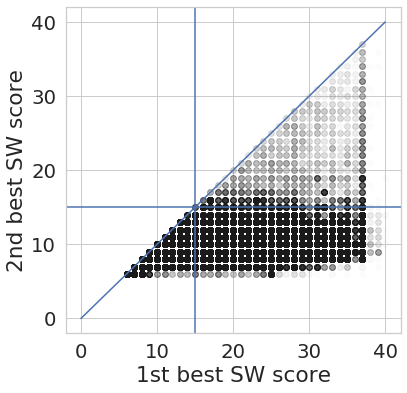

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

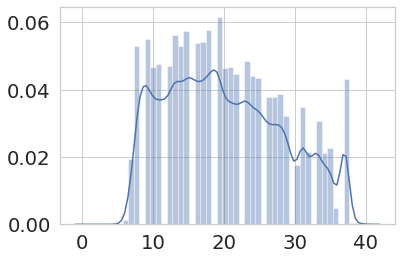

In [17]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [18]:
run_id = re.findall(r"runid_(.*)_[\d]+_[\d]+.tsv", sw_tsv)[0]

In [19]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [20]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [21]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/all_7d0acceaaa1cedac5617dbfac6122f3441e9e66c.tsv'

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [22]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.replace(" ", "").split(",")

In [23]:
molbit_set_in_run = str(int(run_data.get("molbit_set")))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)
molbits_on_flowcell = list(np.unique(molbits_on_flowcell))

## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [24]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/software/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [25]:
len(accept_molbit)

298473

In [26]:
sum(accept_molbit)

210197

In [27]:
sum(accept_molbit) / len(accept_molbit)


0.7042412546528497

## Extract the best-aligned molbit, across ONLY the extant molbits

In [28]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_on_flowcell]

In [29]:
extant_sw = sw.loc[:, extant_sw_cols]

In [30]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [31]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [32]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [33]:
n_extant_is_best

209676

Percentage of well-aligned reads that belong to the true set

In [34]:
n_extant_is_best/len(sw_accepted)

0.997521372807414

Read counts for each molbit

In [35]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('1', 2068),
 ('12', 5940),
 ('15', 6069),
 ('17', 2399),
 ('19', 8016),
 ('22', 1682),
 ('23', 670),
 ('25', 2718),
 ('28', 965),
 ('29', 3235),
 ('32', 4383),
 ('35', 1573),
 ('37', 3728),
 ('38', 582),
 ('39', 3048),
 ('4', 828),
 ('40', 5370),
 ('43', 11566),
 ('45', 2854),
 ('46', 1107),
 ('5', 9183),
 ('50', 5852),
 ('51', 5063),
 ('52', 1206),
 ('54', 5490),
 ('57', 2302),
 ('62', 5068),
 ('63', 4532),
 ('65', 2877),
 ('66', 4531),
 ('67', 2151),
 ('68', 6236),
 ('69', 2358),
 ('7', 2311),
 ('70', 1149),
 ('73', 2971),
 ('75', 4125),
 ('76', 248),
 ('78', 633),
 ('79', 911),
 ('80', 3133),
 ('81', 7023),
 ('83', 1797),
 ('85', 7428),
 ('86', 5922),
 ('87', 3659),
 ('88', 5037),
 ('89', 6906),
 ('9', 19228),
 ('90', 4763),
 ('92', 4129),
 ('93', 3174)]

In [36]:
print("\n".join([str(x) for x in c]))

2068
5940
6069
2399
8016
1682
670
2718
965
3235
4383
1573
3728
582
3048
828
5370
11566
2854
1107
9183
5852
5063
1206
5490
2302
5068
4532
2877
4531
2151
6236
2358
2311
1149
2971
4125
248
633
911
3133
7023
1797
7428
5922
3659
5037
6906
19228
4763
4129
3174


## Extract the best-aligned molbit, across ONLY the current run's molbits

In [37]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [38]:
extant_sw = sw.loc[:, extant_sw_cols]

In [39]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [40]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [41]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [42]:
n_extant_is_best

209710

Percentage of well-aligned reads that belong to the true set

In [43]:
n_extant_is_best/len(sw_accepted)

0.997683125829579

Read counts for each molbit

In [44]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('1', 2068),
 ('12', 5938),
 ('15', 6067),
 ('17', 2399),
 ('19', 8011),
 ('22', 1682),
 ('23', 669),
 ('25', 2718),
 ('28', 964),
 ('29', 3234),
 ('32', 4382),
 ('35', 1570),
 ('37', 3728),
 ('38', 582),
 ('39', 3045),
 ('4', 830),
 ('40', 5370),
 ('43', 11564),
 ('45', 2854),
 ('46', 1106),
 ('5', 9185),
 ('50', 5851),
 ('51', 5062),
 ('52', 1206),
 ('54', 5487),
 ('57', 2302),
 ('62', 5067),
 ('63', 4532),
 ('65', 2877),
 ('66', 4531),
 ('67', 2151),
 ('68', 6233),
 ('69', 2358),
 ('7', 2315),
 ('70', 1148),
 ('73', 2971),
 ('75', 4125),
 ('76', 248),
 ('78', 633),
 ('79', 911),
 ('80', 3131),
 ('81', 7023),
 ('83', 1797),
 ('85', 7427),
 ('86', 5922),
 ('87', 3659),
 ('88', 5035),
 ('89', 6905),
 ('9', 19258),
 ('90', 4763),
 ('92', 4129),
 ('93', 3174)]

In [45]:
l = []
for i in range(0, 96, 16):
    l.extend(range(i, i+8))

In [46]:
", ".join([str(x) for x in l])

'0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19, 20, 21, 22, 23, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49, 50, 51, 52, 53, 54, 55, 64, 65, 66, 67, 68, 69, 70, 71, 80, 81, 82, 83, 84, 85, 86, 87'

## Get counts for all molbits

In [47]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

0
2067
1
0
830
9183
1
2311
6
19206
0
2
5936
29
3
6055
0
2370
0
8010
3
0
1680
667
0
2715
1
4
963
3234
2
0
4382
2
1
1568
54
3686
582
3045
5367
2
1
11563
0
2854
1084
11
2
149
5849
5061
1206
52
5485
26
0
2301
56
0
0
8
5038
4531
1
2877
4525
2146
6223
2348
1146
0
3
2971
4
4011
239
0
633
875
3131
7022
45
1796
0
7425
5922
3626
5035
6905
4762
16
4089
3174
2
0


# Plot read counts

In [57]:
def plot_read_counts(labels, counts, labels_on_flowcell, labels_in_run,
                     possible_labels=None, ax=None, vmax=None, title_note=None):
    from matplotlib.patches import Patch
    if vmax is None:
        vmax = max(counts) + max(counts)
    if ax == None:
        fig, ax = plt.subplots(figsize=(30, 8))
    if possible_labels is None:
        possible_labels = labels[:]
    g = sns.barplot(x=labels, y=counts, order=possible_labels, ax=ax)
    title = "#/reads identified per barcode"
    if title_note is not None:
        title += "\n(%s)" % title_note
    ax.set_title(title)
    ax.set_xlabel("Barcode ID")
    ax.set_ylabel("Read counts")
    ax.set_ylim([0, vmax])
    
    prev_text_height = 0
    for j, label in enumerate(possible_labels):
        if label in labels:
            count = counts[labels.index(label)]
        else:
            count = 0
        if label == "-1":
            continue

#         try:
#             label = int(label)
#         except:
#             pass
        
        if label in labels_in_run:
            g.containers[0].get_children()[j].set_facecolor("tab:red")
            font_kwargs = {"color": "tab:red", "weight": "bold"} 
        elif label in labels_on_flowcell:
            g.containers[0].get_children()[j].set_facecolor("tab:blue")
            font_kwargs = {"color": "k", "weight": "bold"}
        else:
            g.containers[0].get_children()[j].set_facecolor("k")
            font_kwargs = {"color": "k", "weight": "normal"}
            
        diff = prev_text_height - (count + 0.01 * vmax)
        if count < 100:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif diff < 0 and np.abs(diff) < vmax * .06:
            text_height = np.max([prev_text_height + .035 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif np.abs(diff) < vmax * .05:
            text_height = np.min([prev_text_height - .01 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        else:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        prev_text_height = text_height
        
    legend_elements = [Patch(facecolor='k', edgecolor='k',
                         label='never been run on this flowcell'),
                       Patch(facecolor='tab:blue', edgecolor='tab:blue',
                         label='prev run on flowcell'),
                       Patch(facecolor='tab:red', edgecolor='tab:red',
                         label='current run on flowcell')]
    leg = ax.legend(handles=legend_elements)
    t1, t2, t3 = leg.get_texts()
    t2._fontproperties = t1._fontproperties.copy()
    t3._fontproperties = t1._fontproperties.copy()
    t2.set_weight('bold')
    t3.set_weight('bold')
    t3.set_color("tab:red")
    return ax

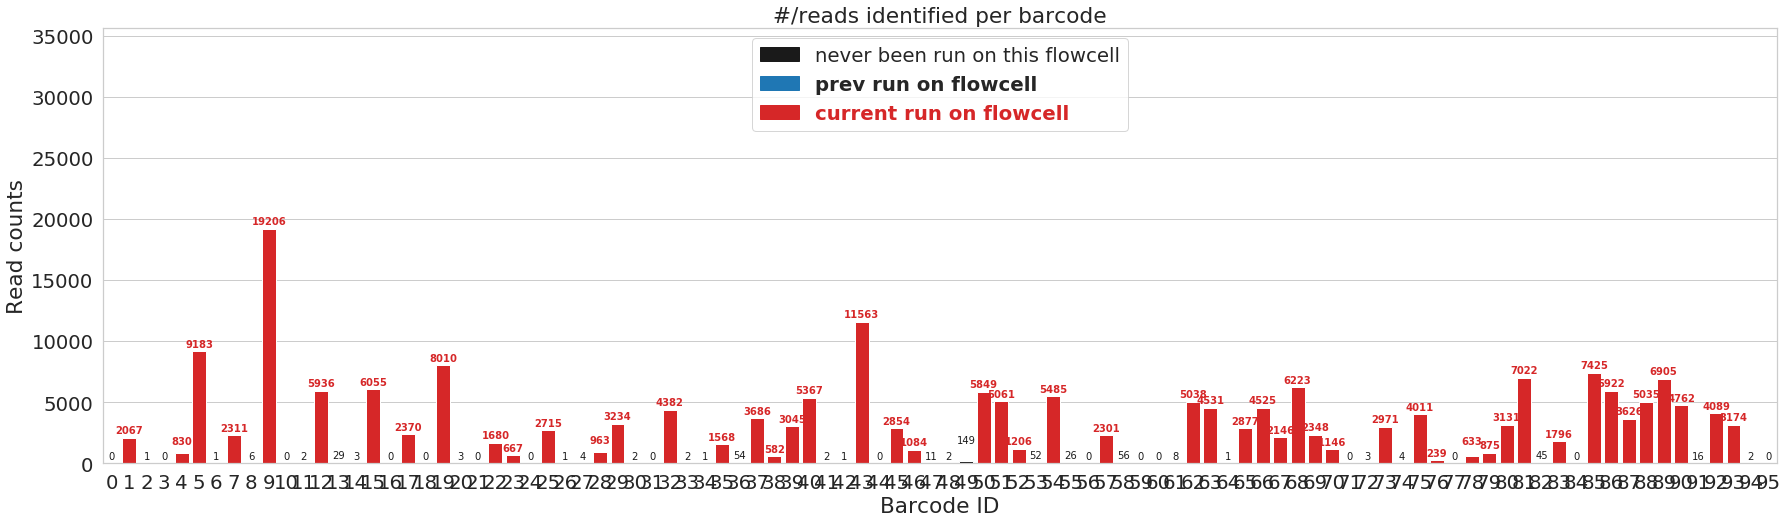

In [58]:
molbits = [str(x) for x in m]
counts = list(c)
on_flowcell = [str(x) for x in molbits_on_flowcell]
in_run = [str(x) for x in molbits_in_run]
poss_molbits = [str(x) for x in range(96)]
plot_read_counts(molbits, counts, on_flowcell, in_run, possible_labels=poss_molbits, vmax=35600)

# Save labels

In [49]:
merged_sw_file


'/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/all_7d0acceaaa1cedac5617dbfac6122f3441e9e66c.tsv'

In [50]:
sw = pd.read_csv(merged_sw_file, sep="\t", index_col=0)
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit
sw["best_molbit_is_in_run"] = sw["best_molbit"].apply(lambda x: x in molbits_in_run)

labels_in_set = sw[np.logical_and(sw["accept_molbit"], sw["best_molbit_is_in_run"])]

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """


In [51]:
sw_label_file = merged_sw_file.replace("all", "labels_for_molbits_in_set")
print(sw_label_file)

/path/to/data/MinION_sequencing_data_20200121/guppy_3.2.2_01_21_20_run_01_exec_20200121/sw/labels_for_molbits_in_set_7d0acceaaa1cedac5617dbfac6122f3441e9e66c.tsv


In [52]:
best_score = np.max(labels_in_set[[f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]], axis=1)
labels_in_set["best_score"] = best_score
labels_in_set = labels_in_set.loc[:, ["best_molbit", "best_score"]]
labels_in_set.columns = ["molbit", "sw_score"]

labels_in_set.to_csv(sw_label_file, sep="\t", index=True)

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Attempt to scale the counts

In [53]:
scaling_factor = [ 117.44079692,  296.08219178,   79.3902663 ,   63.8680128 ,
        301.24041812,  106.23305345,   50.35782934,   94.36710933,
        261.39458779,   23.42805573,  236.19903327,  215.71332122,
         72.68457433, 1674.82258065,  359.61558442,   92.43485034,
         55.15762106,  147.49710313,  161.68942521,   41.8235584 ,
         72.38555587,  124.39775226,  207.99019608,  599.71731449,
        410.15625   ,  146.23955432,   81.21546961,  151.60891089,
        265.91895803,   93.01442673,   59.58171206,   41.92334018,
         75.73638033,  100.18461538,  178.88385542,  176.9227836 ,
         35.15      ,   99.06164932,  435.15123095,  124.01737387,
        100.70515917,  113.01108647,  127.24327323,   34.53376496,
        113.68327138,   86.11075652,  317.00898411,  239.53629243,
         83.78780013,  276.0384821 ,   89.75808133,   32.18069662,
        250.71262136,  310.93798916,   76.84392204,  187.19391084,
        211.31315136,  165.0372093 ,   71.34651475,  403.21590909,
         35.59571978,  201.41721854,  126.01242971,   66.43719769,
       1425.49333333,  102.0477251 ,   39.45092251,   84.89571202,
         68.85702018,  148.00922935,  204.68155712,  104.81568627,
         66.45394046,  150.09968354,   32.68883529,   74.21318208,
        797.16806723,   93.0257416 ,  348.76102941,  372.37684004,
         95.12844828,   56.96902426,  143.82404692,  231.58237146,
        171.5491644 ,   65.69370442,   68.64634526,  119.36073553,
        128.91764706,   32.27093687,  114.79353994,  433.62242374,
         92.13242249,  293.19063545,  129.10751105,   86.49629995]

In [54]:
m

array(['1', '11', '12', '13', '14', '15', '17', '19', '2', '20', '22',
       '23', '25', '26', '27', '28', '29', '30', '32', '33', '34', '35',
       '36', '37', '38', '39', '4', '40', '41', '42', '43', '45', '46',
       '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '57',
       '58', '6', '61', '62', '63', '64', '65', '66', '67', '68', '69',
       '7', '70', '72', '73', '74', '75', '76', '78', '79', '8', '80',
       '81', '82', '83', '85', '86', '87', '88', '89', '9', '90', '91',
       '92', '93', '94'], dtype=object)

In [55]:
molbits = [str(x) for x in m]
counts = list(c / np.array(scaling_factor))
on_flowcell = [str(x) for x in molbits_on_flowcell]
in_run = [str(x) for x in molbits_in_run if str(x) not in medium]
poss_molbits = [str(x) for x in range(96)]
plot_read_counts(molbits, counts, on_flowcell, in_run, possible_labels=[str(x) for x in range(96)], vmax=1500)

ValueError: operands could not be broadcast together with shapes (80,) (96,) 